In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# build pipeline to import Tfrec data
monet_file_dir = 'D:\myenv\kaggle-competition\gan-getting-started\monet_tfrec'
photo_file_dir = 'D:\myenv\kaggle-competition\gan-getting-started\photo_tfrec'
monet_file_names = [os.path.join(monet_file_dir, file) for file in os.listdir(monet_file_dir)]
photo_file_names = [os.path.join(photo_file_dir, file) for file in os.listdir(photo_file_dir)]
monet_raw_dataset = tf.data.TFRecordDataset(monet_file_names)
photo_raw_dataset = tf.data.TFRecordDataset(photo_file_names)

In [4]:
photo_raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [5]:
def format_fcn(example):
    image = tf.image.decode_jpeg(example)
    image = (tf.cast(image, dtype=tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image
def parse_function(example):
    features = {
        'target': tf.io.FixedLenFeature([], dtype=tf.string),
        'image': tf.io.FixedLenFeature([], dtype=tf.string),
        'image_name': tf.io.FixedLenFeature([], dtype=tf.string),
    }
    parsed_image = tf.io.parse_single_example(example, features)
    return format_fcn(parsed_image['image'])

In [6]:
formatted_monet_image = monet_raw_dataset.map(parse_function)
formatted_photo_image = photo_raw_dataset.map(parse_function)

In [157]:
dataset = formatted_monet_image
dataset = tf.convert_to_tensor(list(dataset))
dataset = tf.image.resize(dataset, size=[28,28])
dataset = tf.image.rgb_to_grayscale(dataset)

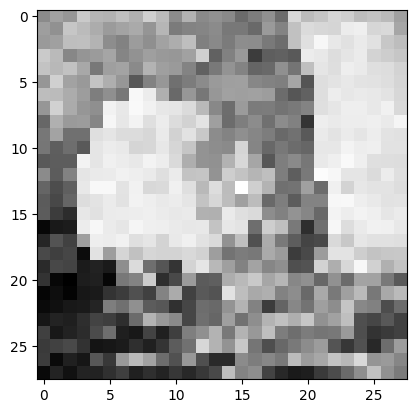

In [131]:
plt.imshow(dataset[0,:,:], cmap='grey')

In [158]:
dataset = tf.data.Dataset.from_tensor_slices(dataset).batch(1)

In [32]:
for raw in monet_raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw.numpy())
        print(example)

features {
  feature {
    key: "target"
    value {
      bytes_list {
        value: "monet"
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\001,\001,\000\000\377\333\000C\000\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\004\003\002\002\002\002\005\004\004\003\004\006\005\006\006\006\005\006\006\006\007\t\010\006\007\t\007\006\006\010\013\010\t\n\n\n\n\n\006\010\013\014\013\n\014\t\n\n\n\377\333\000C\001\002\002\002\002\002\002\005\003\003\005\n\007\006\007\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\377\300\000\021\010\001\000\001\000\003\001\021\000\002\021\001\003\021\001\377\304\000\036\000\000\002\002\003\001\001\001\001\000\000\000\000\000\000\000\000\006\007\004\005\003\010\t\002\000\n\001\377\304\000K\020\000\002\001\002\004\003\005\005\004\t\003\001\007\001\t\000\003\004\005\006\023\000\002\007#\0243C\010\022\025Sc\

In [159]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    model.add(tf.keras.layers.Reshape((7,7,256)))
    model.add(tf.keras.layers.Conv2DTranspose(128, (5,5), padding='same', strides=(1,1), use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5,5), padding='same', strides=(2,2), use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5,5), padding='same', strides=(2,2), use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [160]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [31]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [161]:
# Defining loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [162]:
# Defining optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [163]:
batch_size = 1
epochs = 50
noise_dims = 100
num_examples_to_generate = 1
seed = tf.random.normal([num_examples_to_generate, noise_dims])

# training step
@tf.function
def train_step(image):
    noise = tf.random.normal([batch_size, noise_dims])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(noise, training=True)
        real_output = discriminator(image, training=True)
        fake_output = discriminator(generated_image, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [117]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            train_step(batch)

In [164]:
train(dataset, epochs)

KeyboardInterrupt: 